<a href="https://colab.research.google.com/github/Kritarth-Dandapat/Pupil-Detection-Desktop-Application/blob/main/Google_Collab_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d tthien/shanghaitech

Dataset URL: https://www.kaggle.com/datasets/tthien/shanghaitech
License(s): unknown
 98% 326M/333M [00:03<00:00, 113MB/s]
100% 333M/333M [00:03<00:00, 101MB/s]


In [ ]:
! unzip shanghaitech.zip

Archive:  shanghaitech.zip
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_10.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_100.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_101.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_102.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_103.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_104.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_105.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_106.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_107.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_108.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_109.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_11.mat  
  inflating: ShanghaiTech/pa

In [ ]:
dataset_dir_part_A = { "train": "/content/ShanghaiTech/part_A/train_data",
                      "test": "/content/ShanghaiTech/part_A/test_data" }
dataset_dir_part_B = { "train": "/content/ShanghaiTech/part_B/train_data",
                      "test": "/content/ShanghaiTech/part_B/test_data"}

In [ ]:
IN_X,IN_Y=768,1024
OUT_X,OUT_Y=96,128
SUBSAMPLING_FACTOR=IN_X//OUT_X

In [ ]:
import numpy as np

def gauss_distribution(x,u=0,sigma=10):
    return np.expand_dims(1/(np.sqrt(2*np.pi*(sigma**2)))*np.exp(-(0.5)*(((x-u)/sigma)**2)),axis=0)

In [ ]:
def get_density_map_gaussian(im, points, gaussian_radius=4):
    density_map = np.zeros((OUT_X, OUT_Y))
    w, h = OUT_Y, OUT_X
    num_gt = len(points)

    for point in points:
        point = np.round(point).astype(int)
        point[0], point[1] = min(h-1, point[1]), min(w-1, point[0])
        x = np.linspace(-gaussian_radius, gaussian_radius, (gaussian_radius*2)+1)
        gaussian_map = np.multiply(gauss_distribution(x), gauss_distribution(x).T)
        gaussian_map /= np.sum(gaussian_map)

        x_left, x_right, y_up, y_down = 0, gaussian_map.shape[1], 0, gaussian_map.shape[0]
        x_right = gaussian_map.shape[1]  # Initialize x_right with a default value
        if point[1] < gaussian_radius:
            x_left = gaussian_radius - point[1]
        if point[0] < gaussian_radius:
            y_up = gaussian_radius - point[0]
        if point[1] + gaussian_radius >= w:
            x_right = gaussian_map.shape[1] - (gaussian_radius + point[1] - w) - 1
        if point[0] + gaussian_radius >= h:
            y_down = gaussian_map.shape[0] - (gaussian_radius + point[0] - h) - 1
        density_map[
            max(0, point[0] - gaussian_radius):min(density_map.shape[0], point[0] + gaussian_radius + 1),
            max(0, point[1] - gaussian_radius):min(density_map.shape[1], point[1] + gaussian_radius + 1),
        ] += gaussian_map[y_up:y_down, x_left:x_right]
    density_map /= np.sum(density_map / len(points))
    return density_map


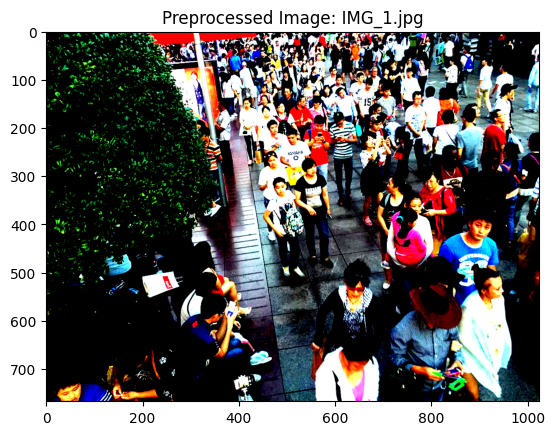

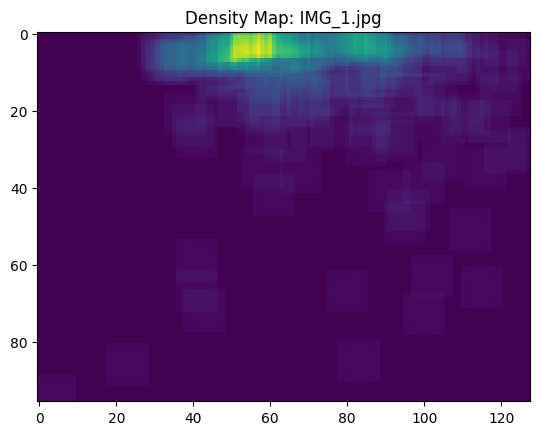

In [ ]:
import tensorflow.keras.preprocessing.image as kpi
import numpy as np
import matplotlib.pyplot as plt
import scipy  # Corrected import for scipy.io

# Assuming `dataset_dir_part_B` is a dictionary containing paths
train_images_dir = dataset_dir_part_B["train"] + "/images/"  # Path to training images
train_maps_dir = dataset_dir_part_B["train"] + "/ground-truth/"  # Path to ground truth maps

IN = 'IMG_1'

try:
    # Load the image using Keras' load_img with target size for resizing
    img = kpi.load_img(train_images_dir + IN + ".jpg", target_size=(IN_X, IN_Y))

    # Convert the image to a NumPy array and handle potential errors
    if img is None:
        raise ValueError("Image not found at specified path.")
    im_array = kpi.img_to_array(img)

    # Normalize the image (assuming image channels are BGR for OpenCV)
    im_array = im_array.astype('float32') / 255.0  # Normalize to range [0, 1]
    im_array[..., 0] = (im_array[..., 0] - np.mean(im_array[..., 0])) / np.std(im_array[..., 0])
    im_array[..., 1] = (im_array[..., 1] - np.mean(im_array[..., 1])) / np.std(im_array[..., 1])
    im_array[..., 2] = (im_array[..., 2] - np.mean(im_array[..., 2])) / np.std(im_array[..., 2])

    # Display the preprocessed image
    plt.imshow(im_array)
    plt.title(f"Preprocessed Image: {IN}.jpg")
    plt.show()

    # Load the ground truth map (optional)
    mat = scipy.io.loadmat(train_maps_dir + "GT_" + IN + ".mat")
    # print(mat["image_info"][0][0][0][0][0])
    points=mat['image_info'][0][0][0][0][0]
    points/=SUBSAMPLING_FACTOR

    density_map_present=get_density_map_gaussian(im_array,points,gaussian_radius=5)

    plt.imshow(density_map_present)
    plt.title(f"Density Map: {IN}.jpg")
    plt.show()
except (ValueError, IOError) as e:
    print(f"An error occurred: {e}")



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import scipy.io


class DataGenerator(tf.keras.utils.Sequence):
    def __init__ (self, images, maps, batch_size,SUBSAMPLING_FACTOR=8):

        self.images = images
        self.maps = maps
        self.batch_size = batch_size
        self.train_image_list=os.listdir(images)
        self.SUBSAMPLING_FACTOR=SUBSAMPLING_FACTOR

    def __len__(self):
        return 10
        # return int(np.floor(len(self.train_image_list)/self.batch_size))

    def __getitem__(self, idx):
        x,y = self.__data_generation(idx)
        return x,y

    def get_density_map_gaussian(im, points, gaussian_radius=4):
      density_map = np.zeros((OUT_X, OUT_Y))
      w, h = OUT_Y, OUT_X
      num_gt = len(points)

      for point in points:
          point = np.round(point).astype(int)
          point[0], point[1] = min(h-1, point[1]), min(w-1, point[0])
          x = np.linspace(-gaussian_radius, gaussian_radius, (gaussian_radius*2)+1)
          gaussian_map = np.multiply(gauss_distribution(x), gauss_distribution(x).T)
          gaussian_map /= np.sum(gaussian_map)

          x_left, x_right, y_up, y_down = 0, gaussian_map.shape[1], 0, gaussian_map.shape[0]
          x_right = gaussian_map.shape[1]  # Initialize x_right with a default value
          if point[1] < gaussian_radius:
              x_left = gaussian_radius - point[1]
          if point[0] < gaussian_radius:
              y_up = gaussian_radius - point[0]
          if point[1] + gaussian_radius >= w:
              x_right = gaussian_map.shape[1] - (gaussian_radius + point[1] - w) - 1
          if point[0] + gaussian_radius >= h:
              y_down = gaussian_map.shape[0] - (gaussian_radius + point[0] - h) - 1
          density_map[
              max(0, point[0] - gaussian_radius):min(density_map.shape[0], point[0] + gaussian_radius + 1),
              max(0, point[1] - gaussian_radius):min(density_map.shape[1], point[1] + gaussian_radius + 1),
          ] += gaussian_map[y_up:y_down, x_left:x_right]
      density_map /= np.sum(density_map / len(points))
      return density_map

    def __data_generation(self, idx):
        x = []
        y = []

        for j in range(idx*self.batch_size, (idx+1)*self.batch_size):

            im_array=img_to_array(load_img(self.images+os.listdir(self.images)[j],target_size=(IN_X,IN_Y)))
            im_array/=255.
            im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
            im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
            im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])
            x.append(im_array)
            mat=scipy.io.loadmat(self.maps+os.listdir(self.maps)[j])
            points=mat['image_info'][0][0][0][0][0]
            points/=self.SUBSAMPLING_FACTOR

            density_map_present=get_density_map_gaussian(im_array,points,gaussian_radius=20)
            y.append(density_map_present)
        return tf.convert_to_tensor(x),tf.convert_to_tensor(y)

In [ ]:
train_images=dataset_dir_part_B["train"] + "/images/"
train_maps=dataset_dir_part_B["train"] + "/ground-truth/"
val_images=dataset_dir_part_B["test"] + "/images/"
val_maps=dataset_dir_part_B["test"] + "/ground-truth/"

LR=1e-4
BATCH_SIZE=1
EPOCH=1000

In [ ]:
train_gen = DataGenerator(train_images, train_maps, batch_size=BATCH_SIZE)
val_gen = DataGenerator(val_images, val_maps, BATCH_SIZE)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

INPUT_DIM=96

def get_base_model():
    base_model = VGG16(
        weights='imagenet',
        input_shape=(IN_X,IN_Y,3),
        include_top=False,)

    block4_conv3=[base_model.get_layer(layer_name).output for layer_name in ["block4_conv3"]]

    return Model(
        inputs=[base_model.inputs],outputs=[block4_conv3]
    )

get_base_model().summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 768, 1024, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 768, 1024, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 768, 1024, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 384, 512, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 384, 512, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 384, 512, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 192, 256, 128)     0  

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import RandomNormal



inputs=tf.keras.Input(shape=(IN_X,IN_Y,3))
x=get_base_model()(inputs)
init=RandomNormal(0.01)
x = x[0]

x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(256, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(128, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(64, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(1, (1,1), activation = 'relu', dilation_rate=1,kernel_initializer=init,padding='same')(x)

out=Reshape((96,128))(x)
model=tf.keras.Model(inputs=inputs,outputs=out)
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 768, 1024, 3)]    0         
                                                                 
 model_16 (Functional)       [(None, 96, 128, 512)]    7635264   
                                                                 
 conv2d_25 (Conv2D)          (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_26 (Conv2D)          (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_27 (Conv2D)          (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_28 (Conv2D)          (None, 96, 128, 256)      1179904   
                                                                 
 conv2d_29 (Conv2D)          (None, 96, 128, 128)      295

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
def custom_loss(y_true,y_pred):
    return tf.sqrt(tf.math.reduce_sum(tf.math.square(y_true - y_pred)))

In [ ]:
LR = 1e-5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=custom_loss,
    metrics=['mae'],
    run_egarly = True
    )
checkpoint_filepath = 'people_counting/CSRNet.h5'

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(train_gen,validation_data=val_gen,epochs=EPOCH,callbacks=[model_checkpoint_callback])

Epoch 1/1000
10/10 [==============================] - 58s 6s/step - loss: 55453320.0000 - mae: 292316.0625 - val_loss: 27528682.0000 - val_mae: 102456.7344
Epoch 2/1000
10/10 [==============================] - 55s 6s/step - loss: 18195046.0000 - mae: 68298.2422 - val_loss: 9950218.0000 - val_mae: 34676.9609
Epoch 3/1000
10/10 [==============================] - 55s 6s/step - loss: 6165315.0000 - mae: 21407.8555 - val_loss: 3669128.7500 - val_mae: 10839.5283
Epoch 4/1000
10/10 [==============================] - 55s 6s/step - loss: 2408097.5000 - mae: 6435.7280 - val_loss: 2012401.0000 - val_mae: 4254.2104
Epoch 5/1000
10/10 [==============================] - 55s 6s/step - loss: 1370983.3750 - mae: 2472.6909 - val_loss: 1497975.2500 - val_mae: 2482.8677
Epoch 6/1000
10/10 [==============================] - 55s 6s/step - loss: 1029404.6250 - mae: 1366.2581 - val_loss: 1292846.8750 - val_mae: 1888.9240
Epoch 7/1000
10/10 [==============================] - 55s 6s/step - loss: 895065.3125 - m

# Testing

In [ ]:
IN ='...'

im_array=img_to_array(load_img(train_image+IN_'.jpg',target_size=(IN_X,IN_Y)))
im_array/=255.
im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])

plt.figure(figsize=(20,12))
plt.imhow(im_array)

output=mode.predict(tf.expand_dims(im_array,axis=0))
output=np.reshape(output,(OUT_X,OUT_Y))

n_people=np.sum(output)
mat=scipy.io.loadmat(train_maps+'GT_'+IN+'.mat')
points=mat['image_info'][0][0][0][0][0]
points/=SUBSAMPLING_FACTOR

num_gt=np.squeeze(points).shape[0]
print("The actual number of people is=",num_gt)
print("The predicted number of people is =",n_people)

plt.figure(figsize=(20,12))
plt.imshow(output)